<a href="https://colab.research.google.com/github/psaw/hse-ai24-ml/blob/main/Chocolate_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline-решение

## Импорт библиотек, загрузка данных

In [87]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [3]:
train_df = pd.read_csv(TRAIN)

## Обзор данных, подготовка к обучению

In [4]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


Удаляем все строки с пропусками

In [6]:
train_df.dropna(axis=0, inplace=True)

Выделяем матрицу объект-признак и вектор с целевой переменной

In [54]:
X = train_df # .drop('Rating', axis=1)
y = train_df['Rating']

## Преобразование данных

In [55]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1253 non-null   object 
 1   Specific Bean Origin  1253 non-null   object 
 2   REF                   1253 non-null   int64  
 3   Review                1253 non-null   int64  
 4   Cocoa Percent         1253 non-null   object 
 5   Company Location      1253 non-null   object 
 6   Rating                1253 non-null   float64
 7   Bean Type             1253 non-null   object 
 8   Broad Bean Origin     1253 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 97.9+ KB


In [58]:
def cocoa_percent_transformer(X):
    X['Cocoa Percent_numeric'] = X['Cocoa Percent'].str.rstrip('%').astype(float)
    return X


def split_and_replace(X, column_name, separator, replace_value):
    X[column_name+'_cat'] = X[column_name].str.split(separator, expand=True)[0].replace(replace_value, np.nan)
    return X


def clean_df(df):
    _df = cocoa_percent_transformer(df)
    print("1: ", _df.shape)
    _df = split_and_replace(_df, 'Broad Bean Origin', ',', '\xa0')
    print("2: ", _df.shape)
    _df = split_and_replace(_df, 'Specific Bean Origin', ',', '\xa0')
    print("3: ", _df.shape)
    _df = split_and_replace(_df, 'Bean Type', r'[ ,(]', '\xa0')
    print("4: ", _df.shape)
    print("5: ", _df.shape)
    # Объединение с оригинальными данными, за исключением удаляемых столбцов
    _df = _df.drop(['REF', 'Cocoa Percent', 'Bean Type', 'Broad Bean Origin', 'Specific Bean Origin'], axis=1)
    print("6: ", _df.shape)
    return _df

print("in: ", X.shape)
X_new = clean_df(X.copy())
print("out: ", X_new.shape)
X_new

in:  (1253, 9)
1:  (1253, 10)
2:  (1253, 11)
3:  (1253, 12)
4:  (1253, 13)
5:  (1253, 13)
6:  (1253, 8)
out:  (1253, 8)


,Company,Review,Company Location,Rating,Cocoa Percent_numeric,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
0,Willie's Cacao,2009,U.K.,3.25,72.0,Venezuela,Rio Caribe,Trinitario
1,Beschle (Felchlin),2010,Switzerland,3.50,72.0,Venezuela,Ocumare,NaN
2,Dark Forest,2015,U.S.A.,3.00,70.0,Tanzania,Tanzania,NaN
3,Brasstown aka It's Chocolate,2013,U.S.A.,3.00,72.0,Dominican Republic,Cooproagro,Trinitario
4,Pralus,2006,France,3.50,75.0,Indonesia,Java,Criollo
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,2009,U.K.,3.00,80.0,Madagascar,Madagascar,Criollo
1251,Marana,2016,Peru,2.75,70.0,Peru,Cusco,NaN
1252,Arete,2015,U.S.A.,3.50,68.0,Peru,Nacional,Forastero
1253,Fresco,2011,U.S.A.,3.50,72.0,Dominican Republic,Conacado,NaN


#### Биннирование признака `Cocoa Percent_numeric`

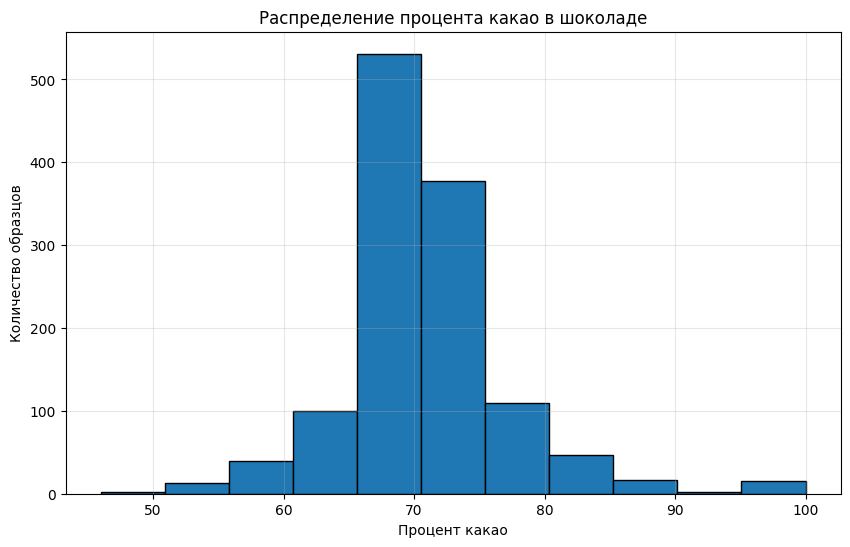

In [142]:
plt.figure(figsize=(10, 6))
plt.hist(X_new['Cocoa Percent_numeric'], bins=11, edgecolor='black')
plt.title('Распределение процента какао в шоколаде')
plt.xlabel('Процент какао')
plt.ylabel('Количество образцов')
plt.grid(True, alpha=0.3)
plt.show()


In [143]:
from sklearn.preprocessing import KBinsDiscretizer

# Создаем экземпляр KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='kmeans', random_state=42)
discretizer.fit(X_new[['Cocoa Percent_numeric']])
X_new['Cocoa Percent_numeric_binned'] = discretizer.transform(X_new[['Cocoa Percent_numeric']])


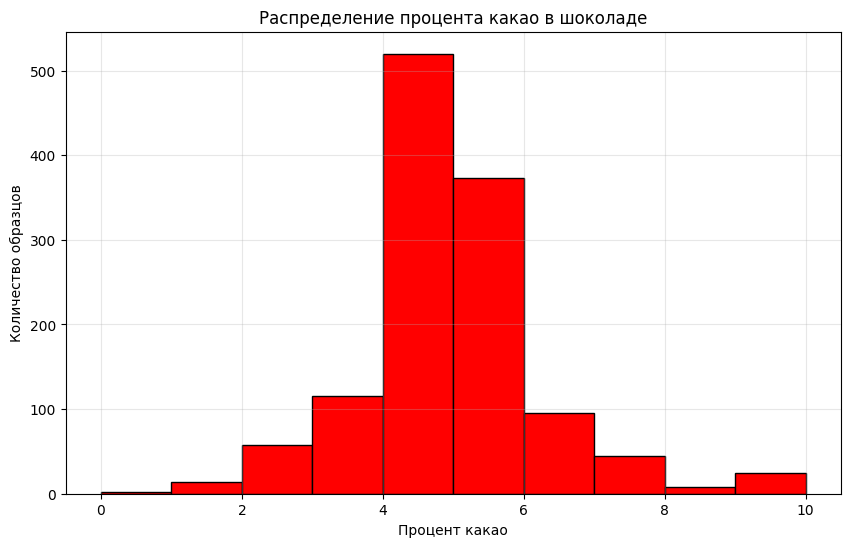

In [220]:
plt.figure(figsize=(10, 6))
plt.hist(X_new['Cocoa Percent_numeric_binned'], color='red', edgecolor='black')
plt.title('Распределение процента какао в шоколаде')
plt.xlabel('Процент какао')
plt.ylabel('Количество образцов')
plt.grid(True, alpha=0.3)
plt.show()


In [221]:
X_new['Cocoa Percent_numeric_binned'].value_counts()

Cocoa Percent_numeric_binned
4.0     520
5.0     373
3.0     115
6.0      95
2.0      57
7.0      44
10.0     15
1.0      14
9.0      10
8.0       8
0.0       2
Name: count, dtype: int64

In [222]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       1253 non-null   object 
 1   Review                        1253 non-null   int64  
 2   Company Location              1253 non-null   object 
 3   Rating                        1253 non-null   float64
 4   Cocoa Percent_numeric         1253 non-null   float64
 5   Specific Bean Origin_cat      1253 non-null   object 
 6   Bean Type_cat                 625 non-null    object 
 7   Cocoa Percent_numeric_binned  1253 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 120.4+ KB


In [223]:
X_new.head()

,Company,Review,Company Location,Rating,Cocoa Percent_numeric,Specific Bean Origin_cat,Bean Type_cat,Cocoa Percent_numeric_binned
0,Willie's Cacao,2009,U.K.,3.25,72.0,Rio Caribe,Trinitario,5.0
1,Beschle (Felchlin),2010,Switzerland,3.50,72.0,Ocumare,NaN,5.0
2,Dark Forest,2015,U.S.A.,3.00,70.0,Tanzania,NaN,4.0
3,Brasstown aka It's Chocolate,2013,U.S.A.,3.00,72.0,Cooproagro,Trinitario,5.0
4,Pralus,2006,France,3.50,75.0,Java,Criollo,5.0


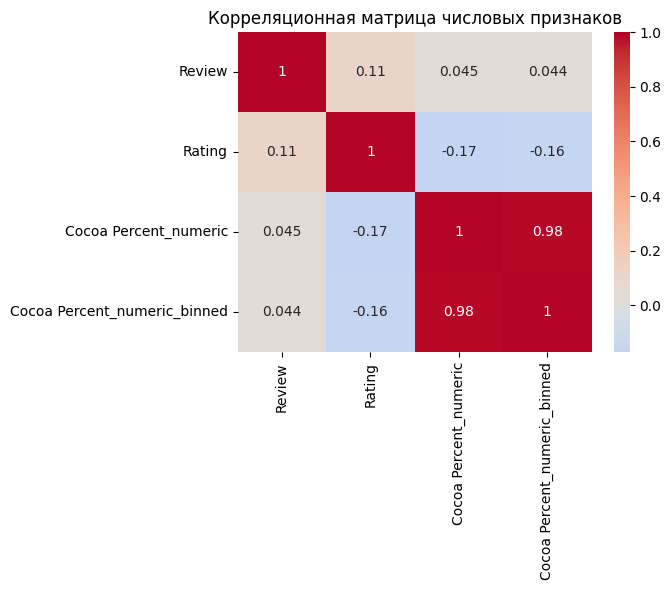

In [145]:
# Создаем корреляционную матрицу
plt.figure(figsize=(7, 6))
correlation_matrix = X_new.select_dtypes(include=['float64', 'int64']).corr()

# Визуализируем корреляционную матрицу с помощью тепловой карты
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()


In [147]:
X_new.describe(include='object')

,Company,Company Location,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
count,1253,1253,1198,1253,625
unique,376,58,66,529,9
top,Soma,U.S.A.,Venezuela,Madagascar,Trinitario
freq,34,520,148,46,293


In [146]:
import association_metrics as am

XC = X_new.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

/Users/yukonoff/code/hse_ai_24/hse-ai24-ml/.venv/lib/python3.12/site-packages/association_metrics/categorical.py:100: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.matrix[x][y] = 1
/Users/yukonoff/code/hse_ai_24/hse-ai24-ml/.venv/lib/py

,Company,Company Location,Broad Bean Origin_cat,Specific Bean Origin_cat,Bean Type_cat
Company,1.000000,0.999651,0.633931,0.653217,0.816914
Company Location,0.999651,1.000000,0.378944,0.735872,0.268613
Broad Bean Origin_cat,0.633931,0.378944,1.000000,0.976352,0.506266
Specific Bean Origin_cat,0.653217,0.735872,0.976352,1.000000,0.871187
Bean Type_cat,0.816914,0.268613,0.506266,0.871187,1.000000


`Broad Bean Origin_cat` и `Specific Bean Origin_cat` сильно связаны
1. попробуем удалить `Broad Bean Origin_cat`, т.к. в нем есть пропуски

In [148]:
X_new.drop('Broad Bean Origin_cat', axis=1, inplace=True)

#### Визуализируем зависимость целевой переменной от категориальных
(перебрал все категории, ничего не увидел)

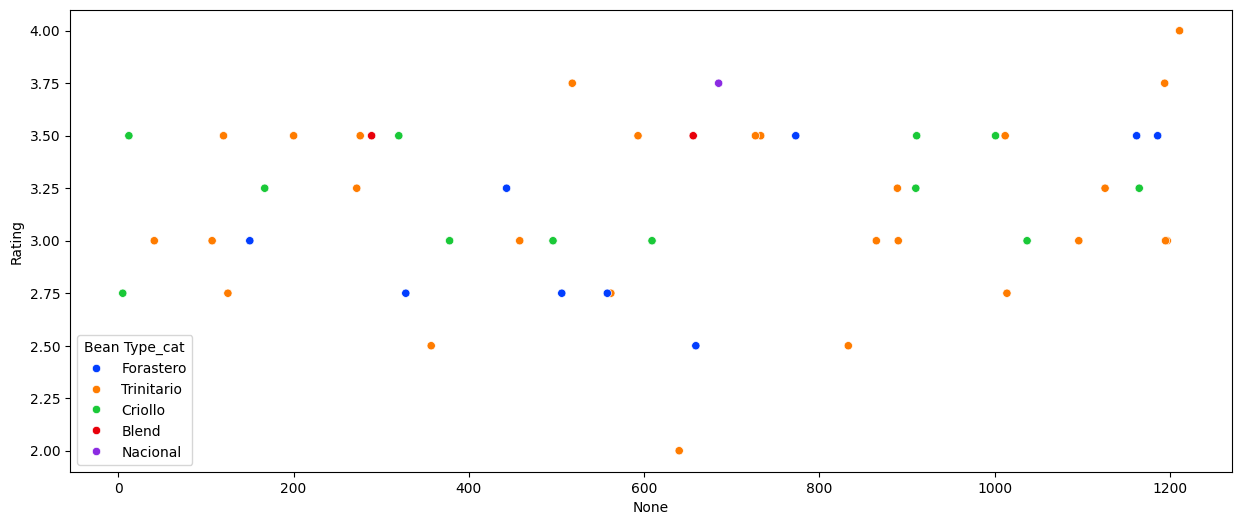

In [219]:
plt.figure(figsize=(15, 6))
XX=X_new.sample(100)
sns.scatterplot(data=XX, x=XX.index, y=y[XX.index], hue='Bean Type_cat', palette='bright');

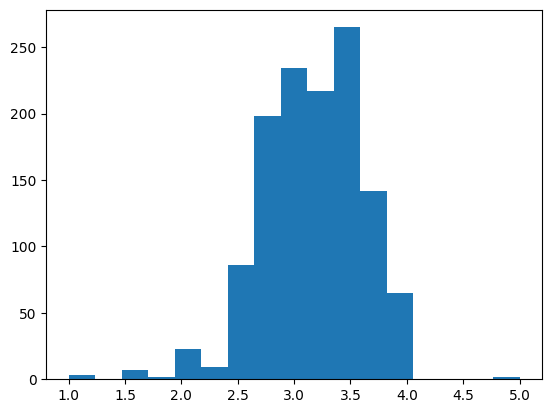

In [235]:
plt.hist(y, bins=17);

Близко к нормальному распределению. Ничего с этим делать не будем.

In [236]:
cat_cols = X_new.columns[X_new.dtypes == 'object']
num_cols = X_new.columns[X_new.dtypes != 'object']

Review


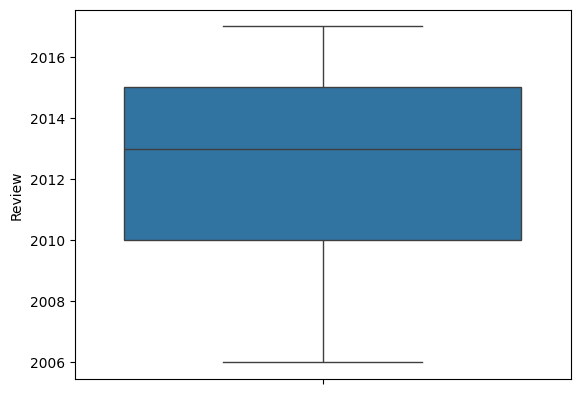

Rating


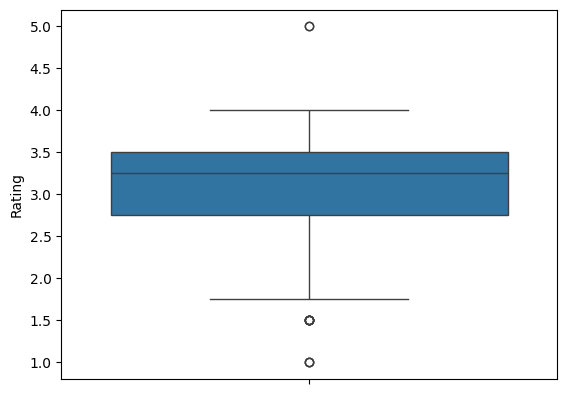

Cocoa Percent_numeric


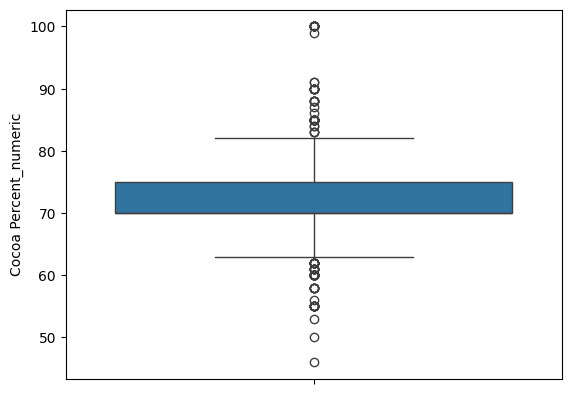

Cocoa Percent_numeric_binned


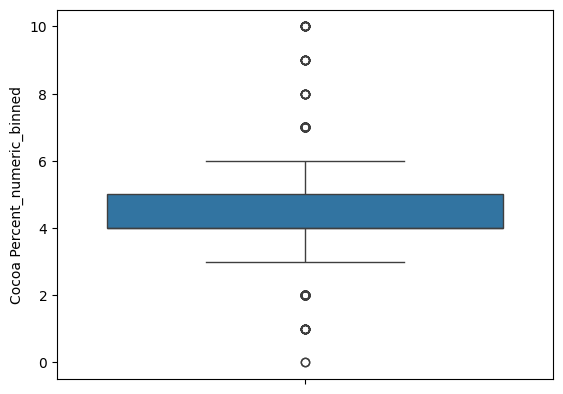

In [238]:
for col in num_cols:
    print(col)
    sns.boxplot(X_new[col])
    plt.show()

Даже экстремальные значения "процент какао" встречаются в жизни, поэтому оставляем как есть.

## Заполнение пропусков

In [241]:
X_new.isna().sum()

Company                         0
Review                          0
Company Location                0
Rating                          0
Cocoa Percent_numeric           0
Specific Bean Origin_cat        0
Bean Type_cat                   0
Cocoa Percent_numeric_binned    0
dtype: int64

Варианты заполнения `Bean Type_cat`:
1. заполнять пропуски в `Bean Type_cat` на основе `Broad Bean Origin_cat` и `Specific Bean Origin_cat`
2. заполнять пропуски в `Bean Type_cat` на основе `Broad Bean Origin_cat`
3. заполнять пропуски в `Bean Type_cat` на основе `Specific Bean Origin_cat`
4. заполнять пропуски в `Bean Type_cat` значением `unknown`


In [240]:
# # Заполнение пропусков в Bean Type_cat на основе группировки по Broad Bean Origin_cat и Specific Bean Origin_cat
# X_train_transformed['Bean Type_cat'] = X_train_transformed.groupby(['Broad Bean Origin_cat', 'Specific Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

# X_new['Bean Type_cat'] = X_new.groupby(['Broad Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

X_new['Bean Type_cat'] = X_new.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_new['Bean Type_cat'].fillna('unknown', inplace=True)

/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_4627/2615024642.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_4627/2615024642.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

In [174]:
# Альтернативный вариант с использованием fillna
def impute_by_group_fillna(df, group_col, target_col):
    '''
    Заполняет пропущенные значения в target_col на основе group_col
    используя mode() для каждой группы
    '''
    return df.groupby(group_col)[target_col].transform(
        lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
    )

# Применяем альтернативный вариант
X_train_transformed['Broad Bean Origin_cat'] = impute_by_group_fillna(
    X_train_transformed, 
    'Specific Bean Origin_cat', 
    'Broad Bean Origin_cat'
)

# Заполнение всех пустых значений Broad Bean Origin_cat значением Specific Bean Origin_cat
X_train_transformed['Broad Bean Origin_cat'].fillna(X_train_transformed['Specific Bean Origin_cat'], inplace=True)


/var/folders/zc/p2mfk5gx5f1cf_g75s52h3940000gn/T/ipykernel_9158/4033484276.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
/var/folders/zc/p2mfk5gx5f1cf_g75s52h3940000gn/T/ipykernel_9158/4033484276.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origina

## Обучение модели

Устанавливаем катбуст и обучаем его с гиперпараметрами по умолчанию на всех данных

In [ ]:
X_new.drop('Rating', axis=1, inplace=True)

In [246]:
X_new.drop('Cocoa Percent_numeric', axis=1, inplace=True)

In [263]:
X_new.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       1253 non-null   object 
 1   Review                        1253 non-null   int64  
 2   Company Location              1253 non-null   object 
 3   Specific Bean Origin_cat      1253 non-null   object 
 4   Bean Type_cat                 1253 non-null   object 
 5   Cocoa Percent_numeric_binned  1253 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 100.8+ KB


In [248]:
cat_features = [0, 2, 3, 4]

In [249]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(cat_features=cat_features)

In [250]:
model.fit(X_new, y)

Learning rate set to 0.042428
0:	learn: 0.4768106	total: 61ms	remaining: 1m
1:	learn: 0.4746848	total: 63.6ms	remaining: 31.7s
2:	learn: 0.4727189	total: 65.9ms	remaining: 21.9s
3:	learn: 0.4705171	total: 69.3ms	remaining: 17.3s
4:	learn: 0.4686536	total: 72.5ms	remaining: 14.4s
5:	learn: 0.4670972	total: 75.1ms	remaining: 12.4s
6:	learn: 0.4650099	total: 76.5ms	remaining: 10.9s
7:	learn: 0.4635832	total: 77.1ms	remaining: 9.56s
8:	learn: 0.4620428	total: 78.7ms	remaining: 8.66s
9:	learn: 0.4601418	total: 81.4ms	remaining: 8.06s
10:	learn: 0.4587023	total: 83.2ms	remaining: 7.48s
11:	learn: 0.4572799	total: 85.9ms	remaining: 7.07s
12:	learn: 0.4556821	total: 87.1ms	remaining: 6.61s
13:	learn: 0.4542018	total: 88.5ms	remaining: 6.23s
14:	learn: 0.4531521	total: 89.3ms	remaining: 5.86s
15:	learn: 0.4521125	total: 90.4ms	remaining: 5.56s
16:	learn: 0.4505394	total: 92.4ms	remaining: 5.34s
17:	learn: 0.4489519	total: 93.8ms	remaining: 5.12s
18:	learn: 0.4474983	total: 95.6ms	remaining: 4.9

In [251]:
model.score(X_new, y)

0.4932230268399286

In [ ]:
# TODO: что можно сделать для улучшения модели:
# 1. Масштабирование признаков
# 2. Заполнение пропусков 
# 3. Удаление выбросов
# 4. Подбор гиперпараметров

## Предсказание на тестовых данных

Загружаем тестовые данные

In [252]:
test_df = pd.read_csv(TEST)

In [253]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             540 non-null    object
 7   Broad Bean Origin     540 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


In [254]:
X_test_transformed = clean_df(test_df.copy())

1:  (540, 9)
2:  (540, 10)
3:  (540, 11)
4:  (540, 12)
5:  (540, 12)
6:  (540, 7)


In [255]:
X_test_transformed['Cocoa Percent_numeric_binned'] = discretizer.transform(X_test_transformed[['Cocoa Percent_numeric']])

In [257]:
X_test_transformed.drop('Broad Bean Origin_cat', axis=1, inplace=True)

In [265]:
X_test_transformed.drop('Cocoa Percent_numeric', axis=1, inplace=True)

In [266]:
X_test_transformed.isna().sum()

Company                         0
Review                          0
Company Location                0
Specific Bean Origin_cat        0
Bean Type_cat                   0
Cocoa Percent_numeric_binned    0
dtype: int64

In [259]:
# Заполнение пропусков в Bean Type_cat на основе группировки по Broad Bean Origin_cat и Specific Bean Origin_cat
# X_test_transformed['Bean Type_cat'] = X_test_transformed.groupby(['Broad Bean Origin_cat', 'Specific Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

# X_test_transformed['Bean Type_cat'] = X_test_transformed.groupby(['Broad Bean Origin_cat'])['Bean Type_cat'].transform(
#     lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

X_test_transformed['Bean Type_cat'] = X_test_transformed.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_test_transformed['Bean Type_cat'].fillna('unknown', inplace=True)

/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_4627/2297547934.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_4627/2297547934.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

In [199]:
# Применяем альтернативный вариант
X_test_transformed['Broad Bean Origin_cat'] = impute_by_group_fillna(
    X_test_transformed, 
    'Specific Bean Origin_cat', 
    'Broad Bean Origin_cat'
)

# Заполнение всех пустых значений Broad Bean Origin_cat значением Specific Bean Origin_cat
X_test_transformed['Broad Bean Origin_cat'].fillna(X_test_transformed['Specific Bean Origin_cat'], inplace=True)


/var/folders/zc/p2mfk5gx5f1cf_g75s52h3940000gn/T/ipykernel_9158/4033484276.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
/var/folders/zc/p2mfk5gx5f1cf_g75s52h3940000gn/T/ipykernel_9158/3386355281.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original

In [267]:
X_test_transformed.isna().sum()

Company                         0
Review                          0
Company Location                0
Specific Bean Origin_cat        0
Bean Type_cat                   0
Cocoa Percent_numeric_binned    0
dtype: int64

In [268]:
X_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       540 non-null    object 
 1   Review                        540 non-null    int64  
 2   Company Location              540 non-null    object 
 3   Specific Bean Origin_cat      540 non-null    object 
 4   Bean Type_cat                 540 non-null    object 
 5   Cocoa Percent_numeric_binned  540 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 25.4+ KB


Делаем предсказание

In [269]:
pred = model.predict(X_test_transformed)

Сохраняем предсказание в файл в нужном формате

In [270]:
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred

test_df[['id','Rating']].to_csv("submission_4.csv", index=False)